I have referred the official bnlearn documentation for implementing the Bayesian network.

    https://www.bnlearn.com/
    https://www.bnlearn.com/examples/useR19-tutorial/
    https://www.bnlearn.com/examples/custom/


In [1]:
# install.packages("BiocManager")
# BiocManager::install("Rgraphviz")
# install.packages("bnlearn")
# install.packages("ggplots")
# install.packages("GGally")
# install.packages("polycor")
# install.packages("dplyr")

In [2]:
library(bnlearn)
library(gplots)
library(GGally)
library(polycor)
library(dplyr)


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘dplyr’


The following object is masked from ‘package:GGally’:

    nasa


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
col_names = "age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num"
col_names = strsplit(col_names, ",")
col_names = as.vector(col_names)
col_names = unlist(col_names)

In [4]:
data = read.csv("processed.cleveland.data",header = FALSE,sep = ",", col.names = col_names)

In [5]:
test_data = sample_n(data, 50)

In [6]:
my_col_names = "age,cp,trestbps,chol,thalach,exang,oldpeak,ca,thal,num"
my_col_names = strsplit(my_col_names, ",")
my_col_names = as.vector(my_col_names)
my_col_names = unlist(my_col_names)

#### Randomly selected attributes

In [7]:
my_col_names

[1] "age"      "cp"       "trestbps" "chol"     "thalach"  "exang"   
 [7] "oldpeak"  "ca"       "thal"     "num"

In [8]:
data = data[,my_col_names]

In [9]:
dim(data)

head(data)

[1] 303  10

,age,cp,trestbps,chol,thalach,exang,oldpeak,ca,thal,num
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,63,1,145,233,150,0,2.3,0,6,0
2,67,4,160,286,108,1,1.5,3,3,2
3,67,4,120,229,129,1,2.6,2,7,1
4,37,3,130,250,187,0,3.5,0,3,0
5,41,2,130,204,172,0,1.4,0,3,0
6,56,2,120,236,178,0,0.8,0,3,0


In [10]:
my_col_names = "age,cp,trestbps,chol,thalach,exang,oldpeak,ca,thal,num"
my_col_names = strsplit(my_col_names, ",")
my_col_names = as.vector(my_col_names)
my_col_names = unlist(my_col_names)


continous_col_names = "age,trestbps,chol,thalach,oldpeak"
continous_col_names = strsplit(continous_col_names, ",")
continous_col_names = as.vector(continous_col_names)
continous_col_names = unlist(continous_col_names)


discrete_col_names = "cp,exang,ca,thal,num"
discrete_col_names = strsplit(discrete_col_names, ",")
discrete_col_names = as.vector(discrete_col_names)
discrete_col_names = unlist(discrete_col_names)

x_col_names = "age,cp,trestbps,chol,thalach,exang,oldpeak"
x_col_names = strsplit(x_col_names, ",")
x_col_names = as.vector(x_col_names)
x_col_names = unlist(x_col_names)

In [11]:
data[,"num"][data[,"num"] > 0]  = 1

In [12]:
data[,discrete_col_names] <- lapply(data[,discrete_col_names], as.factor)
data[,continous_col_names] <- lapply(data[,continous_col_names], as.numeric)

In [13]:
head(data)

,age,cp,trestbps,chol,thalach,exang,oldpeak,ca,thal,num
,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
1,63,1,145,233,150,0,2.3,0,6,0
2,67,4,160,286,108,1,1.5,3,3,1
3,67,4,120,229,129,1,2.6,2,7,1
4,37,3,130,250,187,0,3.5,0,3,0
5,41,2,130,204,172,0,1.4,0,3,0
6,56,2,120,236,178,0,0.8,0,3,0


### Dataset understanding

There is no missing value in the dataframe which is evident from - 

In [14]:
sum(is.na(data)) 

[1] 6

#### For all the continous variables, we do the histogram plot to see if they are Gaussian

In [15]:
head(data[,continous_col_names])
dim(data[,continous_col_names])

,age,trestbps,chol,thalach,oldpeak
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,63,145,233,150,2.3
2,67,160,286,108,1.5
3,67,120,229,129,2.6
4,37,130,250,187,3.5
5,41,130,204,172,1.4
6,56,120,236,178,0.8


[1] 303   5

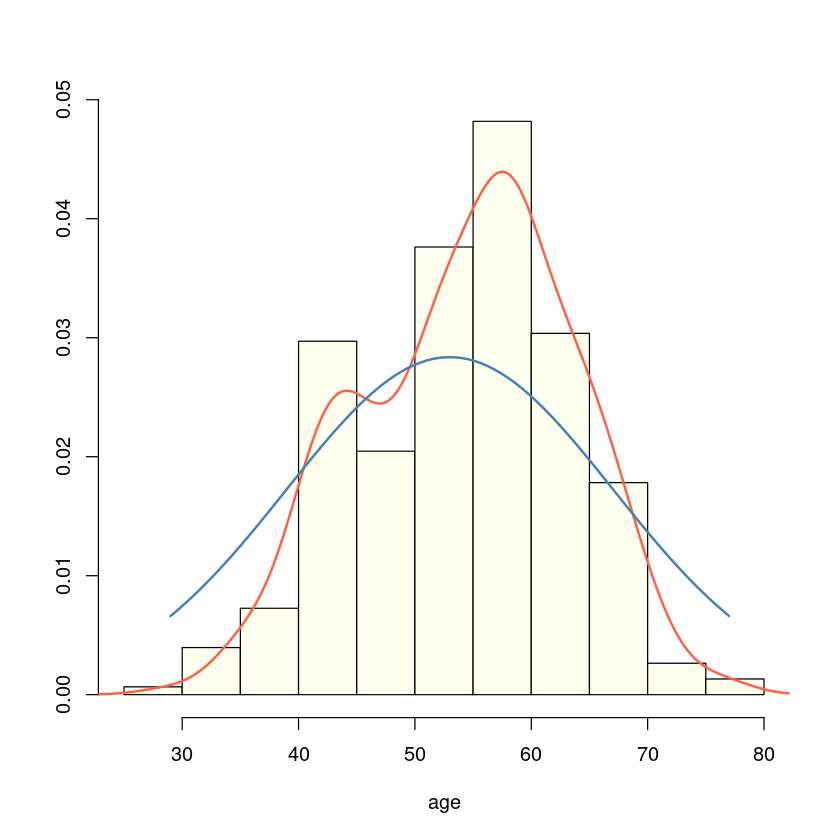

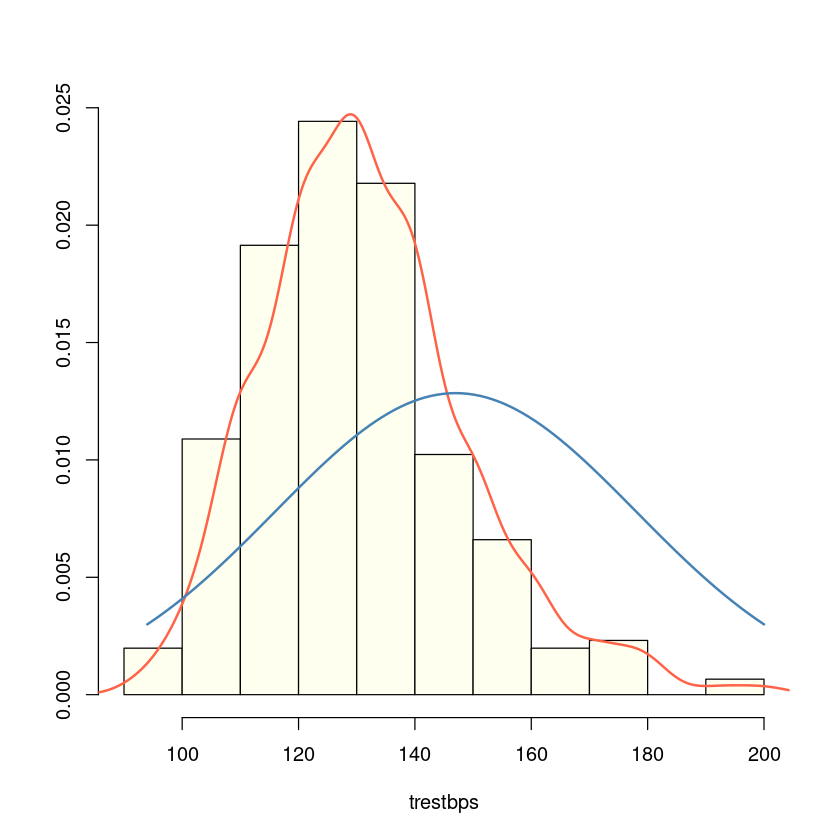

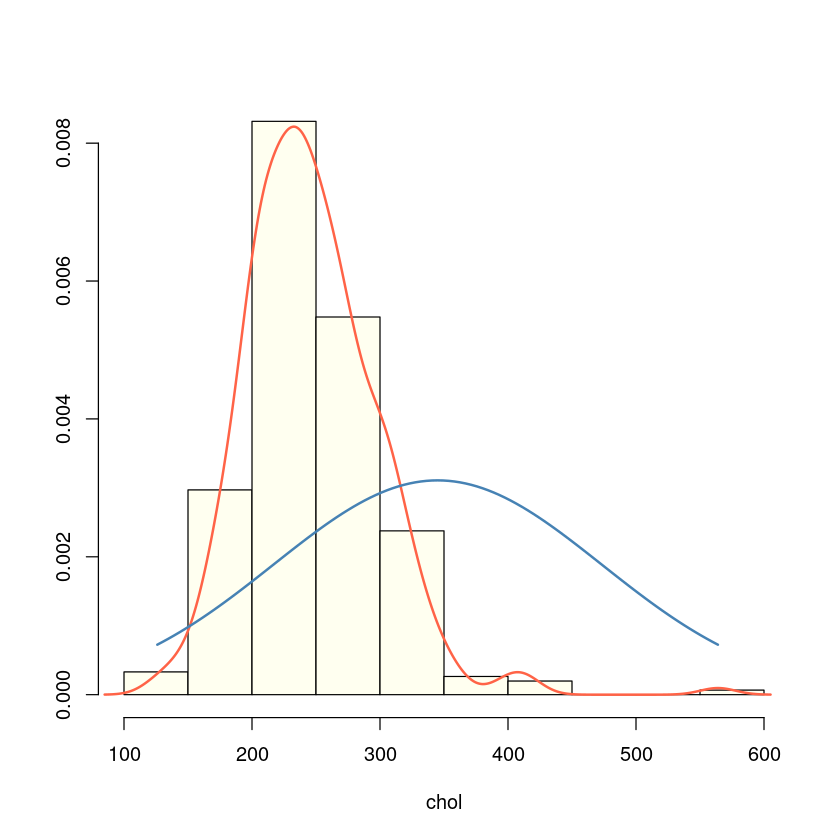

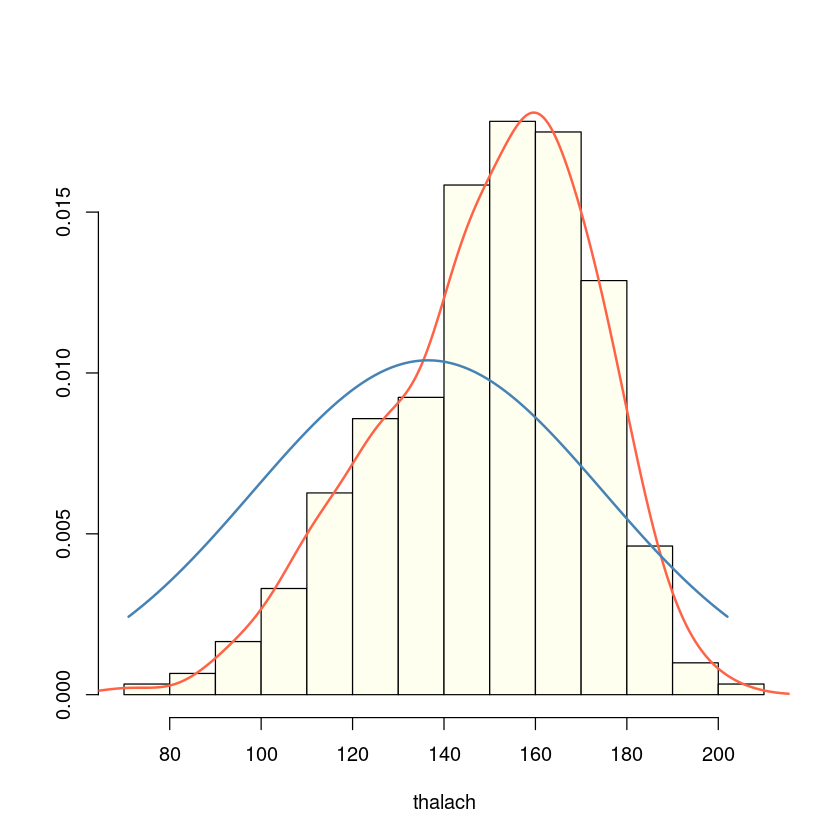

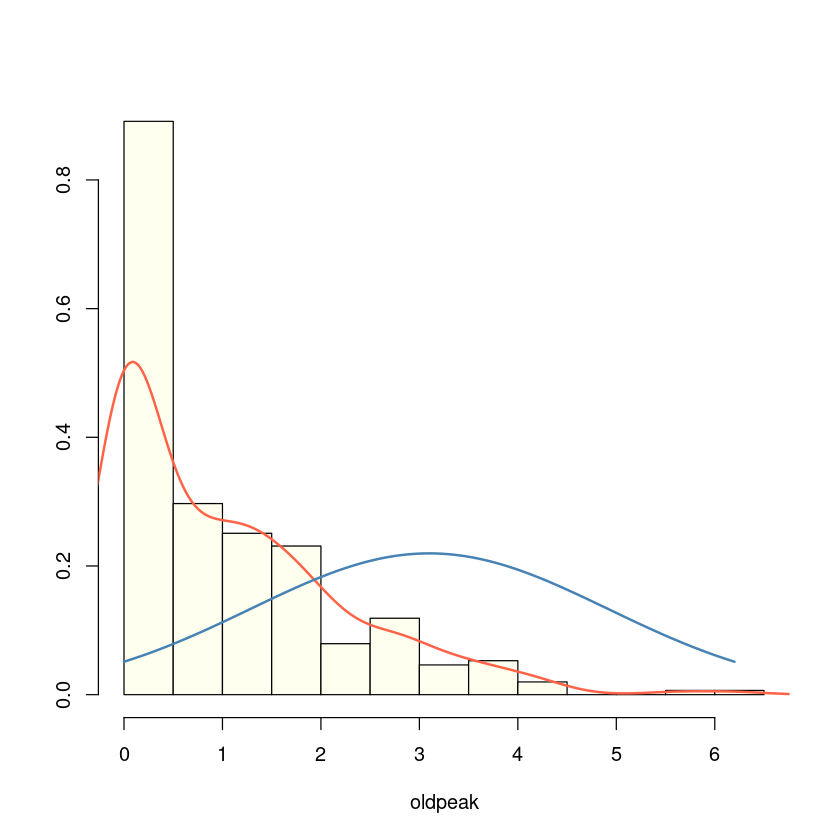

In [16]:
for (var in continous_col_names) {

    x = data[, var]
    hist(x, prob = TRUE, xlab = var, ylab = "", main = "", col = "ivory")
    lines(density(x), lwd = 2, col = "tomato")
    curve(dnorm(x, mean = mean(x), sd = sd(x)), from = min(x), to = max(x),add = TRUE, lwd = 2, col = "steelblue")

}


Most of the continous attributes are close to a Gaussian distribution, but some e.g. oldpeak are not. 

We will deal with that later.

#### Checking relationship between all the feature-pairs

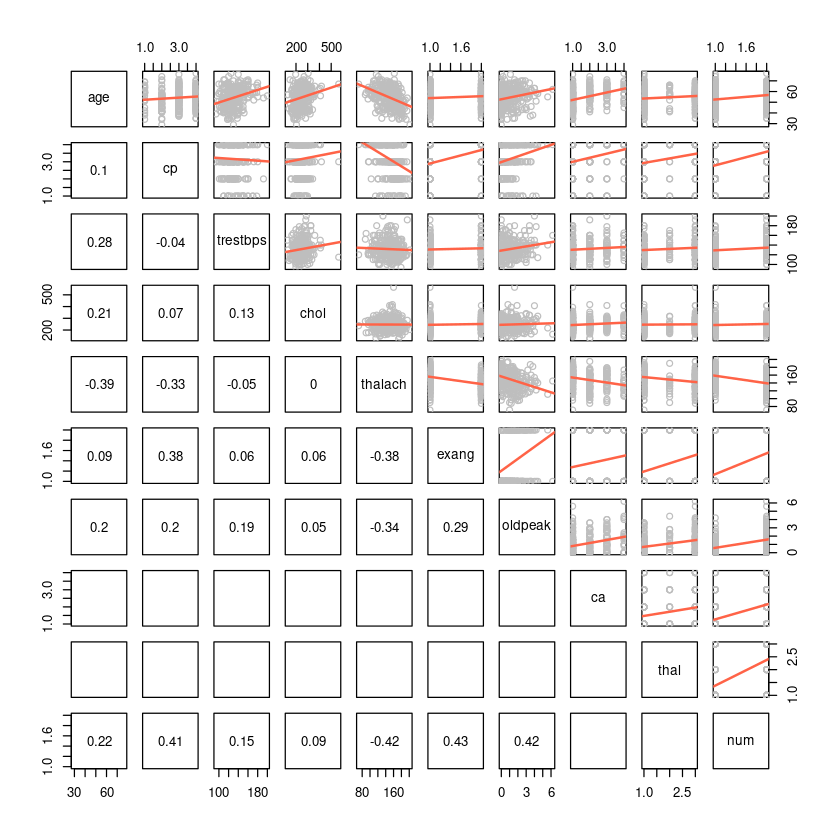

In [17]:
pairs(data,
upper.panel = function(x, y, ...) {
 points(x = x, y = y, col = "grey")
 abline(coef(lm(y ~ x)), col = "tomato", lwd = 2)
},
lower.panel = function(x, y, ...) {
 par(usr = c(0, 1, 0, 1))
 text(x = 0.5, y = 0.5, round(cor(x, y), 2), cex = 1)
}
)

#### Checking correlations between features to get a raw idea of the bayesian-network

In [18]:
correlations_all = hetcor(data,std.err = FALSE)$correlations

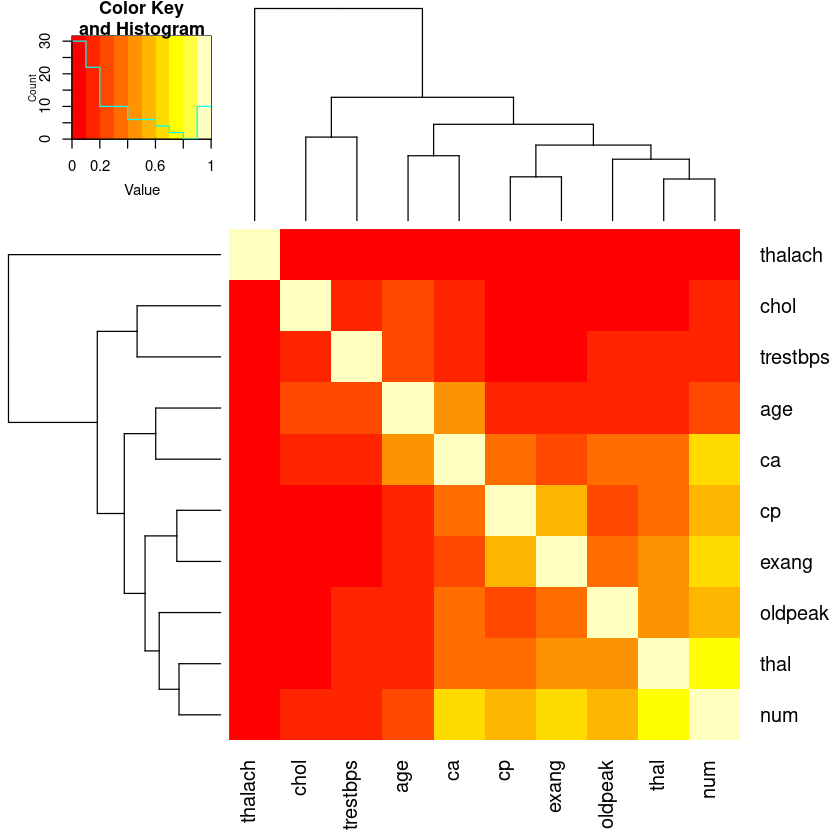

In [19]:
heatmap.2(correlations_all,scale = "none", trace = "none", revC = TRUE, breaks = seq(0, 1, 0.1))

There is definitely a cluster of variables as seen from the heatmap, same is visualized in the graph below.

Loading required namespace: Rgraphviz



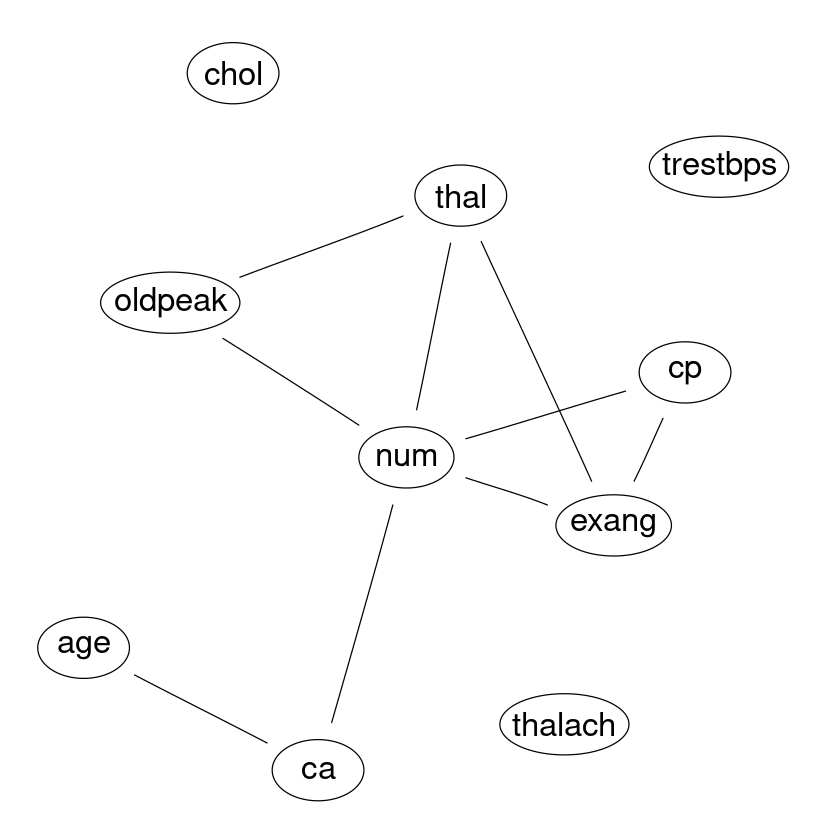

In [20]:
ug = empty.graph(colnames(correlations_all))
amat(ug) = (correlations_all > 0.4) + 0L - diag(1L, nrow(correlations_all))
graphviz.plot(ug, layout = "fdp", shape = "ellipse")

### Structure Learning 
#### We will learn the structure of the Bayesian Network before learning the parameters

Using some information from https://archive.ics.uci.edu/ml/datasets/Heart+Disease one can say that these features should not change when one is changed, so adding a black-list in the network corresponding to these attributes.

In [21]:
bl = tiers2blacklist(list("exang",c("chol", "trestbps")))
bl = rbind(bl, c("exang", "chol"), c("chol", "exang"))

In [22]:
bl

from,to
chol,exang
trestbps,exang
exang,chol
chol,exang


Similarly, adding a white-list for the attributes.

In [23]:
wl = matrix(c("thalach", "trestbps"),ncol = 2, byrow = TRUE, dimnames = list(NULL, c("from", "to")))

In [24]:
wl

from,to
thalach,trestbps


In [25]:
x_data = data[,x_col_names]

In [26]:
data_no_na = data[complete.cases(data), ]

In [27]:
dag = mmhc(data_no_na, whitelist = wl, blacklist = bl)

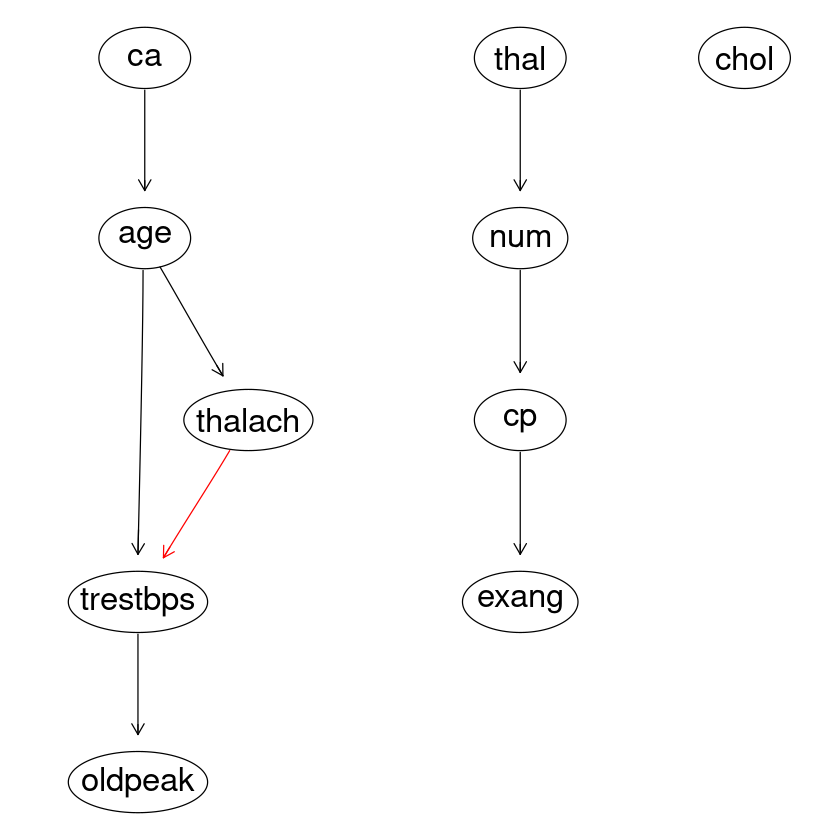

In [28]:
graphviz.plot(dag, shape = "ellipse", highlight = list(arcs = wl))

As we saw, above that some of the continous attributes do not strictly follow the Gaussian distribution, so we use boot.strength to resample data using bootstrapping and to get a better respresentation of the bayesian-network.

In [29]:
strength = boot.strength(data_no_na, R = 200, algorithm = "hc",
                         algorithm.args = list(whitelist = wl, blacklist = bl))

In [30]:
avg = averaged.network(strength)

Warning message in averaged.network.backend(strength = strength, nodes = nodes, :
“arc num -> cp would introduce cycles in the graph, ignoring.”


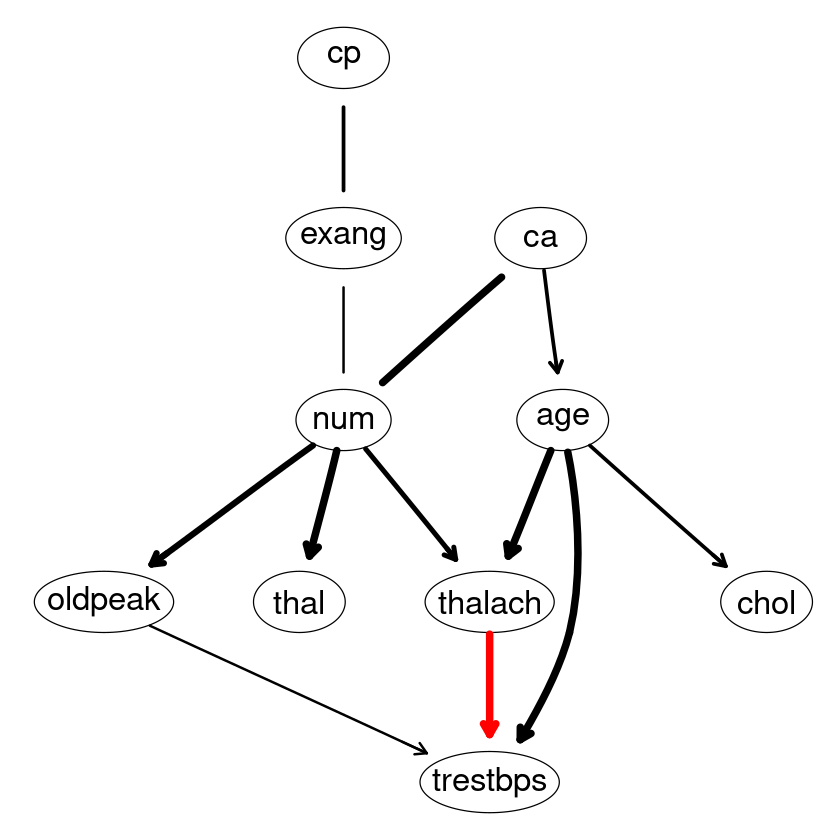

In [31]:
strength.plot(avg, strength, shape = "ellipse", highlight = list(arcs = wl))

#### We try to compare both the networks - learned from data and learned using boot.strength

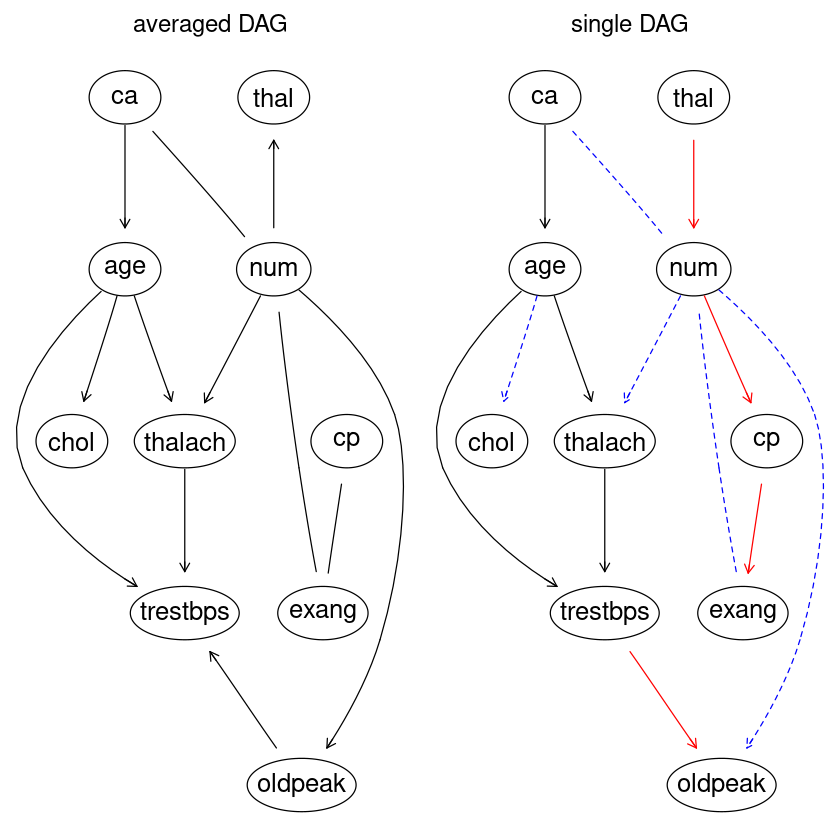

In [32]:
par(mfrow = c(1, 2))
graphviz.compare(avg, dag, shape = "ellipse", main = c("averaged DAG", "single DAG"))

In [33]:
compare(avg, dag)

$tp
[1] 4

$fp
[1] 4

$fn
[1] 8

In [34]:
compare(cpdag(avg, wlbl = TRUE), cpdag(dag, wlbl = TRUE))

$tp
[1] 6

$fp
[1] 2

$fn
[1] 6

In [35]:
nrow(strength[strength$strength > 0.5 & strength$direction > 0.5, ])

[1] 11

In [36]:
simpler = averaged.network(strength, threshold = 0.6)

Warning message in averaged.network.backend(strength = strength, nodes = nodes, :
“arc num -> cp would introduce cycles in the graph, ignoring.”


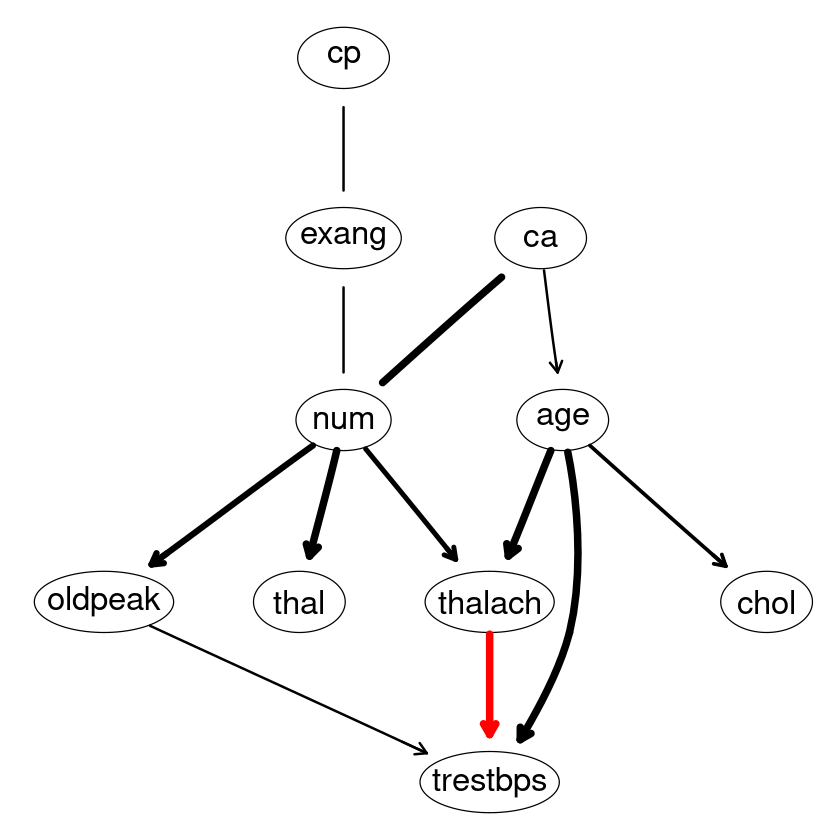

In [37]:
strength.plot(simpler, strength, shape = "ellipse", highlight = list(arcs = wl), threshold = 0.6)

In [38]:
undirected.arcs(simpler)

from,to
cp,exang
exang,cp
exang,num
ca,num
num,exang
num,ca


In [42]:
simpler = set.arc(simpler, from="cp", to="exang")
simpler = set.arc(simpler, from="exang", to="num")
simpler = set.arc(simpler, from="ca", to="num")
# simpler = set.arc(simpler, from="thal", to="num")
# simpler = set.arc(simpler, from="cp", to="num")


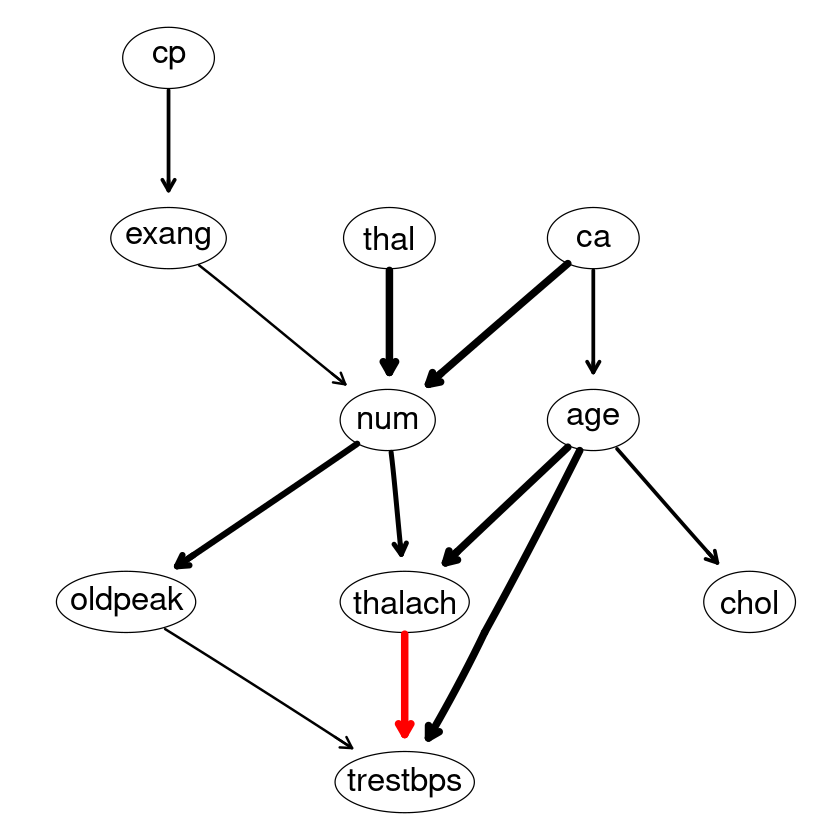

In [43]:
strength.plot(simpler, strength, shape = "ellipse", highlight = list(arcs = wl))

### Parameter Learning

In [44]:
fitted = bn.fit(simpler, data_no_na)

In [45]:
fitted


  Bayesian network parameters

  Parameters of node age (conditional Gaussian distribution)

Conditional density: age | ca
Coefficients:
                    0         1         2         3
(Intercept)  51.68391  57.47692  59.78947  59.90000
Standard deviation of the residuals:
       0         1         2         3  
9.226005  6.876381  6.576608  8.232797  
Discrete parents' configurations:
   ca
0   0
1   1
2   2
3   3

  Parameters of node cp (multinomial distribution)

Conditional probability table:
          1          2          3          4 
0.07744108 0.16498316 0.27946128 0.47811448 

  Parameters of node trestbps (Gaussian distribution)

Conditional density: trestbps | age + thalach + oldpeak
Coefficients:
(Intercept)          age      thalach      oldpeak  
 80.2769148    0.6055481    0.1038890    2.6972546  
Standard deviation of the residuals: 16.77764 

  Parameters of node chol (Gaussian distribution)

Conditional density: chol | age
Coefficients:
(Intercept)          ag

In [46]:
imputed_data = impute(fitted, data)

In [47]:
dim(data)
dim(imputed_data)

[1] 303  10

[1] 303  10

In [48]:
imputed_data =  imputed_data[sample(nrow(imputed_data)),]

In [49]:
test_data = tail(imputed_data,50)
train_data = imputed_data

In [50]:
fitted_all = bn.fit(simpler, train_data)

predicted_test = predict(fitted_all, node = "num", data = test_data)
accuracy_test = sum(test_data[,"num"] == predicted_test) / length(predicted_test)

predicted_train = predict(fitted_all, node = "num", data = train_data)
accuracy_train = sum(train_data[,"num"] == predicted_train) / length(predicted_train)

In [51]:
accuracy_train
accuracy_test

[1] 0.8382838

[1] 0.84